## Comparing both strain sensor on Index MCP angle data and IMU on wrist and palm angle data to camera angle data for any of the APPLIED tests

##  Process flow:  

(1) Load data folder

(2) Plot raw calibrated strain sensor on index MCP which was placed on Phil's angle calibration block

(3) Pick data segments (by index) from plot above for each bend angle to build the calibration curve

(4) Sanity check: compare the quadratic ADC–angle fit against the theoretical model.

(5) Apply the quadratic calibration to convert all trial ADC values to angles

(6) Example for how to plot single trial for 1st application and reapplication

(7) Plot all trials together for 1st application and reapplication

(8) Get per-trial camera timestamp tables from flir.mat (prefix 'ts*')

(9) Match trial ADC timestamps to camera trigger timestamps -> need for error analysis 

(10) Plot Angle from Strain Sensor vs Row Index AND DLC Angle vs Row Index on same plot

(11) Extract IMU trials (same calls as before)

(12) Compute bend angle from two IMU's and plot

(13) Match trial IMU timestamps to camera trigger timestamps -> need for error analysis

(14) Plot Wrist Angle from IMU's vs Row Index AND DLC Angle vs Row Index on same plot




In [570]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [571]:
from config import path_to_repository
from analysis import BallBearingData # class for extracting all data from application and reapplication for ADC, IMU, and Camera Triggers
from analysis import DLC3DBendAngles # class for taking DLC 3d point data and converting to angles 
from analysis import bender_class # class for normalizing adc data, analyzing autobender tests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

Found 3 *_B1_slow folders total (case-insensitive).
  example: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\11_2_25\2025_11_02_14_27_31_B1_slow
First set range: 2025_11_02_14_27_31_B1_slow → 2025_11_02_14_27_31_B1_slow
Second set range: 2025_11_02_14_28_03_B1_slow → 2025_11_02_14_28_03_B1_slow
[WARN] ball_bearing_first: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_11_02_14_27_31_B1_slow has 6 CSVs (including nested)
First set range: 2025_11_02_14_27_31_B1_slow → 2025_11_02_14_27_31_B1_slow
Second set range: 2025_11_02_14_28_03_B1_slow → 2025_11_02_14_28_03_B1_slow
[WARN] ball_bearing_second: Some trials do not have exactly 7 CSVs:
  • Trial 01: 2025_11_02_14_28_03_B1_slow has 6 CSVs (including nested)
Found 3 *_C_Block folders total (case-insensitive).
  example: C:\Users\toppe\OneDrive - CSU Maritime Academy\Documents\GitHub\Strain-Sensor-\CSV Data\11_2_25\2025_11_02_14_20_43_C_Block
First set range: 2025_11_02_14_20_43_C_Block 

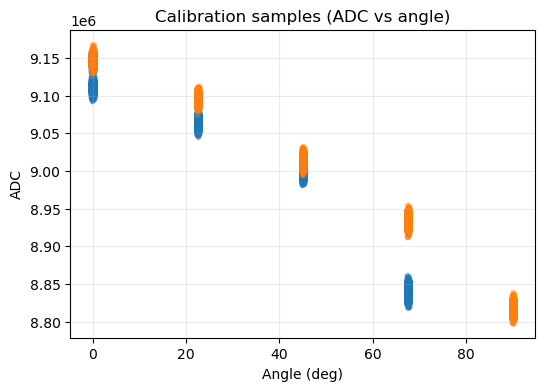

In [572]:
# Upload ball bearing and beaker Trials from particpant
# Upload only the parent *date* folder (e.g., "9_19_25").
# If something fails, verify your folder structure matches the "9_19_25" example.

root_dir="CSV Data/11_2_25"
folder_suffix="B1_slow"

#10_28_25 (Tom)
#10_29_25 (bending data might be okay...check)
#11_2_25 (good)
#11_4_25 (good)

##################### raw adc or imu data for any test ###############################

bb = BallBearingData(
    root_dir=root_dir, # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=2,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix=folder_suffix,     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first  = bb.load_first() # first application
df_second = bb.load_second() # reapplication



adc_trials_first = bb.extract_adc_dfs_by_trial(df_first)  # list of DataFrames 
adc_trials_second = bb.extract_adc_dfs_by_trial(df_second)  # list of DataFrames
#trial1_adc = adc_trials_first[0]  # trial 1 (index 0)

#######################################################################

# upload  csv files for sensor calibration on autobender.  This was only done twice for Tom.  After Tom's experiments, strain sensor only calibrated on Phil's 
renc = os.path.join(path_to_repository , "CSV Data/10_26_25/2025_10_26_15_19_56_C_Autobender/data_rotenc_2025_10_26_15_19_56_C_Autobender.csv")
strain = os.path.join(path_to_repository , "CSV Data/10_26_25/2025_10_26_15_19_56_C_Autobender/data_adc_2025_10_26_15_19_56_C_Autobender.csv")

#################################################################################

# block calibration
bb_hand_c = BallBearingData(
    root_dir=root_dir, # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=1,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix="C_Block",     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first_hand_c  = bb_hand_c.load_first() # first application
df_second_hand_c = bb_hand_c.load_second() # reapplication

# DataFrames (one per trial) using your class’ finder logic (largest matching file)
h_cal_path_first  = bb_hand_c.extract_adc_dfs_by_trial(df_first_hand_c)
h_cal_path_second = bb_hand_c.extract_adc_dfs_by_trial(df_second_hand_c)

# first hand block calibration
h_cal_path_first = h_cal_path_first[0]
h_cal_path_first = h_cal_path_first["adc_ch3"]

# Second hand block calibration
h_cal_path_second = h_cal_path_second[0]
h_cal_path_second = h_cal_path_second["adc_ch3"]


#####################################################################################

bb_cam_c = BallBearingData(
    root_dir=root_dir,
    path_to_repo=path_to_repository,
    n_trials_per_set=1,
    files_per_trial=7,
    folder_suffix="unused_here",  # not used by this method
)

cam_c_df = bb_cam_c.extract_calib_means_by_set(
    exclude_name_contains=("C_Block",),
    exclude_sets=(3, 4),
    make_plot=True,
    overlay_mean=False,
    point_alpha=0.25,
    point_size=10,
    jitter=0.25,
    snap_tol_deg=4.0,   # <-- add this (e.g., 4–5° works well)
)

#####################################################################################


# autobender calibration
bb_auto = BallBearingData(
    root_dir=root_dir, # all that is needed is to upload the parent date folder.  If there are issues with this, check the structure of folder 9_19_25 as an example 
    path_to_repo=path_to_repository,
    n_trials_per_set=1,   # 15 trials of ball bearing reach to pinch, 15 trials of beaker reach to grasp, and the same for reapplication
    files_per_trial=7,
    folder_suffix="C_Autobender",     # this suffic contains data from ball bearing task  
    # Valid folder_suffix values (examples): check the 9_19_25 folder for CSV naming patterns/suffixes
)
df_first_auto  = bb_auto.load_first() # first application
df_second_auto = bb_auto.load_second() # reapplication

# DataFrames (one per trial) using your class’ finder logic (largest matching file)
auto_path_first  = bb_auto.extract_adc_dfs_by_trial(df_first_auto)
auto_path_second = bb_auto.extract_adc_dfs_by_trial(df_second_auto)


# Efirst autobender calibration
#auto_path_first = auto_path_first[0]
#auto_path_first = auto_path_first["adc_ch3"]

#auto_path_second = auto_path_second[0]
#auto_path_second = auto_path_second["adc_ch3"]



## Plot raw calibrated strain sensor on index MCP which was placed on Phil's angle calibration block

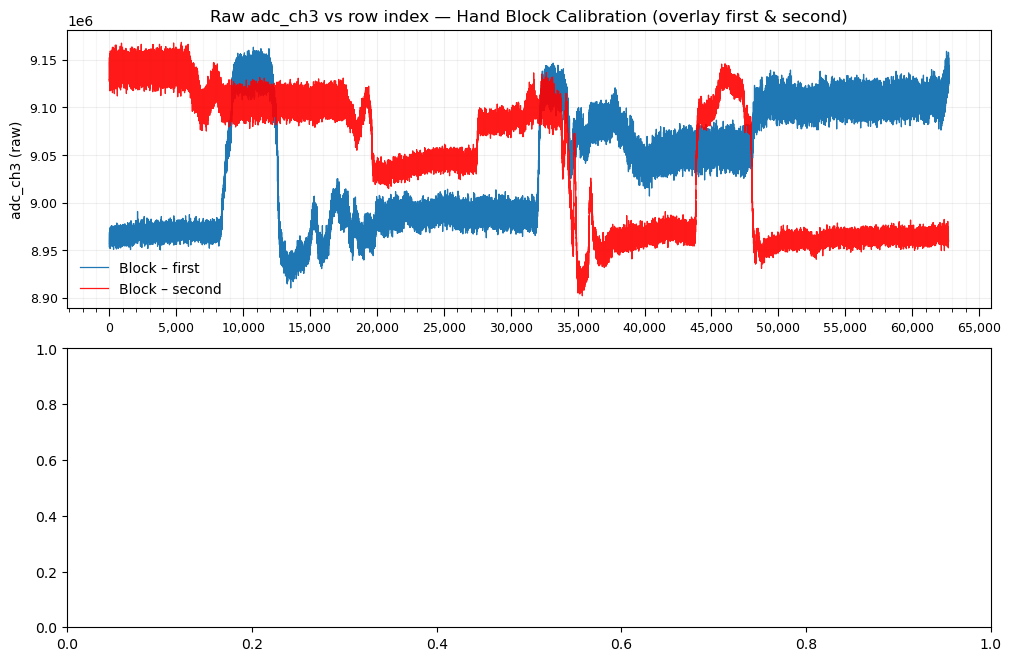

In [574]:
import matplotlib.ticker as mticker

def _to_clean_numeric_series(y):
    s = pd.to_numeric(pd.Series(y), errors="coerce")
    return s.dropna().reset_index(drop=True)

# --- y-series (numeric, clean) ---
y_block_first  = _to_clean_numeric_series(h_cal_path_first)   # hand block, first
y_block_second = _to_clean_numeric_series(h_cal_path_second)  # hand block, second

y_auto_first   = _to_clean_numeric_series(auto_path_first)    # autobender, first
y_auto_second  = _to_clean_numeric_series(auto_path_second)   # autobender, second

# --- x-axes as row indices ---
x_block_first  = np.arange(len(y_block_first))
x_block_second = np.arange(len(y_block_second))
x_auto_first   = np.arange(len(y_auto_first))
x_auto_second  = np.arange(len(y_auto_second))

# ---- Plot: block (top) and autobender (bottom) ----
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6.5), sharex=False, constrained_layout=True)

# ========== TOP: Hand Block calibration (overlay first & second) ==========
ax1.plot(x_block_first,  y_block_first.values,  linewidth=0.9, label="Block – first")       # blue
ax1.plot(x_block_second, y_block_second.values, linewidth=0.9, color="red", alpha=0.9,
         label="Block – second")  # red
ax1.set_title("Raw adc_ch3 vs row index — Hand Block Calibration (overlay first & second)")
ax1.set_ylabel("adc_ch3 (raw)")
ax1.grid(alpha=0.2, which="major")
ax1.grid(alpha=0.1, which="minor", axis="x")
ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
ax1.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
ax1.tick_params(axis="x", which="major", length=6)
ax1.tick_params(axis="x", which="minor", length=3)
ax1.tick_params(axis="both", which="both", labelsize=9)
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))
ax1.legend(loc="best", frameon=False)

# ========== BOTTOM: Autobender calibration (overlay first & second) ==========
#ax2.plot(x_auto_first,  y_auto_first.values,  linewidth=0.9, label="Autobender – first")     # blue
#ax2.plot(x_auto_second, y_auto_second.values, linewidth=0.9, color="red", alpha=0.9,
#         label="Autobender – second")  # red
#ax2.set_title("Raw adc_ch3 vs row index — Autobender (overlay first & second)")
#ax2.set_xlabel("Row index")
#ax2.set_ylabel("adc_ch3 (raw)")
#ax2.grid(alpha=0.2, which="major")
#ax2.grid(alpha=0.1, which="minor", axis="x")
#ax2.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
#ax2.xaxis.set_minor_locator(mticker.AutoMinorLocator(5))
#ax2.tick_params(axis="x", which="major", length=6)
#ax2.tick_params(axis="x", which="minor", length=3)
#ax2.tick_params(axis="both", which="both", labelsize=9)
#ax2.xaxis.set_major_formatter(mticker.FuncFormatter(lambda v, p: f"{int(v):,}"))
#ax2.legend(loc="best", frameon=False)

plt.show()


[preset] 11_2_25 → angles = [0.0, 22.5, 45.0, 67.5, 90.0]


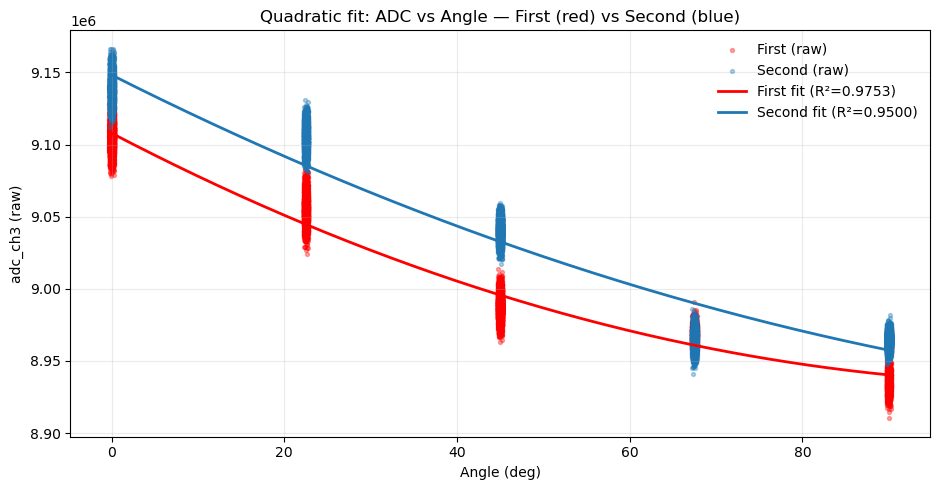

{'c0': 9107858.519380717, 'c1': -3124.648024942293, 'c2': 14.038596035335985, 'r2': 0.9752856848600207, 'n': 16000} {'c0': 9148172.249624725, 'c1': -3014.848190521708, 'c2': 9.956971449881438, 'r2': 0.9500145462380435, 'n': 17000}


In [575]:
import os

PRESETS = {
    "11_7_25": {
        "ranges_first": [
            (1000, 5000),    # 0°
            (11000, 13000),  # 22.5°
            (23000, 25000),  # 45°
            (34000, 37000),  # 67.5°
            (58000, 60000),  # 90°
        ],
        "ranges_second": [
            (60000, 62000),    # 0°
            (50000, 52000),  # 22.5°
            (34000, 36000),  # 45°
            (20000, 22000),  # 67.5°
            (1000, 5000),  # 90°
        ],
        "angles": [0, 22.5, 45, 67.5, 90],
    },
    "10_29_25": {
        "ranges_first": [
            (5400, 5600),   # 0°
            (3700, 4000),   # 22.5°
            (2600, 2800),   # 45°
            (100, 500),     # 67.5°
            (1300, 1400),   # 90°
        ],
        "ranges_second": [
            (5400, 5600),   # 0°
            (3700, 4000),   # 22.5°
            (2600, 2800),   # 45°
            (100, 500),     # 67.5°
            (1300, 1400),   # 90°
        ],
        "angles": [0.0, 22.5, 45.0, 67.5, 90.0],
    },
    "11_2_25": {
        "ranges_first": [
            (55000, 61000),  # 0°
            (43000, 45000),  # 22.5°
            (27000, 31000),  # 45°
            (1000, 4000),    # 67.5°
            (13000, 14000),  # 90°
        ],
        "ranges_second": [
            (1000, 4000),    # 0°
            (13000, 15000),  # 22.5°
            (21000, 25000),  # 45°
            (38000, 41000),  # 67.5°
            (55000, 60000),  # 90°
        ],
        "angles": [0.0, 22.5, 45.0, 67.5, 90.0],
    },
    "11_4_25": {
        "ranges_first": [
            (500, 3000),     # 0°
            (13000, 15000),  # 22.5°
            (30000, 32000),  # 45°
            (50000, 52000),  # 67.5°
            (61000, 62000),  # 87°
        ],
        "ranges_second": [
            (500, 3000),     # 0°
            (13000, 15000),  # 22.5°
            (30000, 32000),  # 45°
            (61000, 62000),  # 67.5°
            (36000, 38000),  # 87°
        ],
        "angles": [0.0, 22.5, 45.0, 67.5, 90.0],
    },
}

def pick_presets(root_dir: str):
    """Return (ranges_first, ranges_second, angles) based on the date folder name."""
    date_key = os.path.basename(os.path.normpath(root_dir))
    preset = PRESETS.get(date_key)
    if preset is None:
        # allow loose matching if folder has extra suffix text
        for k in PRESETS:
            if k in date_key:
                preset = PRESETS[k]
                break
    if preset is None:
        raise KeyError(f"No preset for '{date_key}'. Add to PRESETS.")

    rf, rs, ang = preset["ranges_first"], preset["ranges_second"], preset["angles"]

    # Basic sanity checks
    if not (len(rf) == len(rs) == len(ang)):
        raise ValueError(
            f"Preset '{date_key}' length mismatch: "
            f"len(ranges_first)={len(rf)}, len(ranges_second)={len(rs)}, len(angles)={len(ang)}"
        )
    return rf, rs, ang

# ---- Use it ----
ranges_first, ranges_second, angles = pick_presets(root_dir)

print(f"[preset] {os.path.basename(root_dir)} → angles = {angles}")
res = bb.compare_block_quadratic_vs_angle(
    h_cal_path_first=h_cal_path_first,
    ranges_first=ranges_first,
    h_cal_path_second=h_cal_path_second,
    ranges_second=ranges_second,
    angles=angles,
    max_points_per_range=None,
)
print(res["first"], res["second"])


## Pick data segments (by index) from plot above for each bend angle to build the calibration curve

Theory r_hat: 0.00010000000024990802 R²: 0.8908771330465064
Block1 quad R²: 0.9752856848600177
Cam1 quad R²: 0.9814888311328025


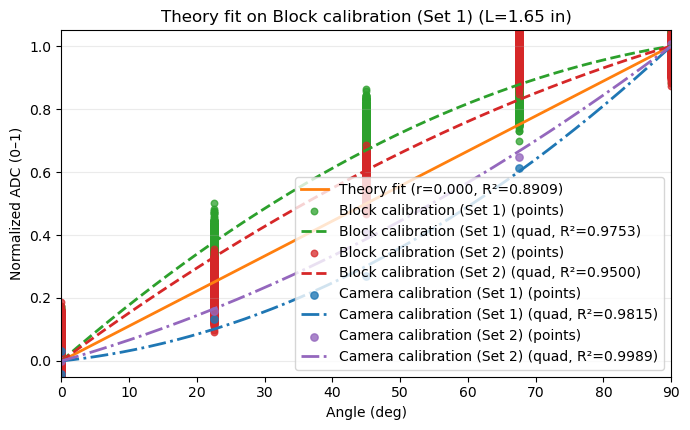

In [577]:
# cam_c_df: DataFrame from extract_calib_means_by_set(...), containing both sets (set_idx == 1/2)
# OR pass a list like [cam_df_first, cam_df_second] and set cam_index_first=0, cam_index_second=1
g = bender_class()
fig, ax = plt.subplots(figsize=(7.0, 4.4))
res = g.fit_knuckle_radius_from_normalized(
    L=1.65, r0=0.5, bounds=(1e-4, 2.45),
    # ---- block sources ----
    h_cal_path_first=h_cal_path_first,
    ranges_first=ranges_first,
    h_cal_path_second=h_cal_path_second,
    ranges_second=ranges_second,
    angles=angles,
    max_points_per_range=None,    # or 200 for flatter windows

    # ---- camera sources ----
    cam_df=cam_c_df,              # or [cam_df_first, cam_df_second]
    # cam_index_first=0, cam_index_second=1,  # only if cam_df is a sequence
    cam_angle_col_hint="angle_deg",
    cam_adc_col_hint="mean_adc",

    # ---- plot & labels ----
    plot=True, ax=ax,
    block1_label="Block calibration (Set 1)",
    block2_label="Block calibration (Set 2)",
    cam1_label="Camera calibration (Set 1)",
    cam2_label="Camera calibration (Set 2)",
    verbose=True
)

print("Theory r_hat:", res["r_hat"], "R²:", res["r2"])
print("Block1 quad R²:", res["overlays"]["block1"]["r2"])
print("Cam1 quad R²:",   res["overlays"]["cam1"]["r2"])


## Apply the quadratic calibration to convert all trial ADC values to angles

[four] coeffs found: blk1=True, blk2=True, cam1=True, cam2=True
[four] anchors blk1: y0=9.10786e+06, y90=8.94035e+06, mode=endpoints_per_cal
[four] anchors cam1: y0=9.12583e+06, y90=8.6562e+06, mode=endpoints_per_cal
[four] anchors blk2: y0=9.14817e+06, y90=8.95749e+06, mode=endpoints_per_cal
[four] anchors cam2: y0=9.14749e+06, y90=8.81876e+06, mode=endpoints_per_cal
[four] OOB first: over=8908, under=0
[four] OOB second: over=2439, under=2


,set_label,trial,timestamp,theta_cam1,theta_blk1,theta_cam2,theta_blk2
0,first_block,1,142738116336,NaN,0.0,NaN,NaN
1,first_block,1,142738116336,NaN,0.0,NaN,NaN
2,first_block,1,142738116336,NaN,0.0,NaN,NaN
3,first_block,1,142738116336,NaN,0.0,NaN,NaN
4,first_block,1,142738116336,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...
27805,second_cam,1,142825000433,NaN,NaN,34.568751,NaN
27806,second_cam,1,142825000433,NaN,NaN,31.327431,NaN
27807,second_cam,1,142825000433,NaN,NaN,35.657747,NaN
27808,second_cam,1,142825000433,NaN,NaN,32.510353,NaN


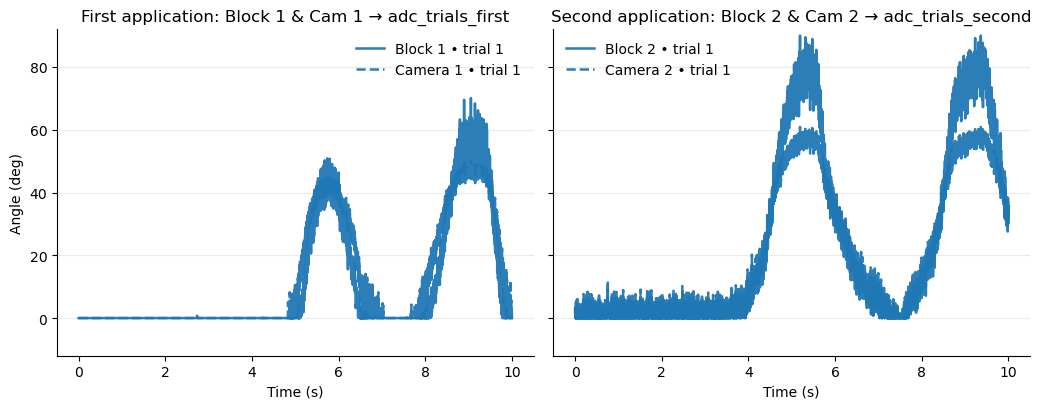

In [579]:
# 1) From your previous fit:
overlays = res["overlays"]   # 'block1','block2','cam1','cam2'

# 2) Make the four theta(t) sets with your preferred anchor strategy:
out = bb.calibrate_four_from_overlays_and_stream(
    overlays,
    adc_trials_first=adc_trials_first,
    adc_trials_second=adc_trials_second,
    anchors_mode="endpoints_per_cal",   #"stream_per_set" or "stream_per_cal", "endpoints_per_cal"
    q_hi=1, q_lo=0,
    deg_min=-10, deg_max=90,
    clip_z=True, clamp_theta=True,
    trial_len_sec=10.0,
    plot=True,
    verbose=True,
)

theta_all = out["theta_all_wide"]
overlays
theta_all


# Get per-trial camera timestamp tables from flir.mat (prefix 'ts*') and DLC 3D point data (two separate dataframes)

This is where you should probably also load the DLC data and combine with cam_trials_first and cam_trials_second.    See my BallBearingClass for examples of how to do that.  

In [581]:
# FIRST application (camera + DLC should be 'first_cam')
cam_trials_first = bb.extract_mat_dfs_by_trial(
    df_first, mat_name="flir.mat", prefix="ts",
    add_labels=True, trial_base=1, set_label="first_cam", include_path=True
)
dlc3d_trials_first = bb.extract_dlc3d_dfs_by_trial(
    df_first,
    add_labels=True, trial_base=1, set_label="first_cam", include_path=True
)

# SECOND application (camera + DLC should be 'second_cam')
cam_trials_second = bb.extract_mat_dfs_by_trial(
    df_second, mat_name="flir.mat", prefix="ts",
    add_labels=True, trial_base=1, set_label="second_cam", include_path=True
)
dlc3d_trials_second = bb.extract_dlc3d_dfs_by_trial(
    df_second,
    add_labels=True, trial_base=1, set_label="second_cam", include_path=True
)

# --- Build DLC angle tables for FIRST and SECOND sets ---


# 2) Coerce headers to the expected MultiIndex format
dlc3d_trials_first  = [bb._coerce_dlc3d_multiindex(d)  for d in dlc3d_trials_first]
dlc3d_trials_second = [bb._coerce_dlc3d_multiindex(d) for d in dlc3d_trials_second]

# 3) Compute DLC-derived angles (returns per-trial augmented dfs + tall table)
aug_first,  tall_first  = bb.compute_dlc3d_angles_by_trial(
    dlc3d_trials_first,  set_label="first_cam",  signed_in_plane=True
)
aug_second, tall_second = bb.compute_dlc3d_angles_by_trial(
    dlc3d_trials_second, set_label="second_cam", signed_in_plane=True
)

# (Optional sanity)
print("len(aug_first) vs cam_trials_first:",  len(aug_first),  "vs", len(cam_trials_first))
print("len(aug_second) vs cam_trials_second:", len(aug_second), "vs", len(cam_trials_second))




len(aug_first) vs cam_trials_first: 1 vs 1
len(aug_second) vs cam_trials_second: 1 vs 1


# Convert 3d Data from DLC to angles and append that column to dataframes created in previous cell

See camera_encoder_cal notebook for how this is done using a class method.  

Once you have the angles, can match timestamps below and do error analysis

In [583]:
# ==== prerequisites ====
import pandas as pd

ALLOWED = {"first_block","first_cam","second_block","second_cam"}
REMAP = {
    "first cam":"first_cam","first block":"first_block",
    "second cam":"second_cam","second block":"second_block",
}

def _canon_label(s: str) -> str:
    s = (s or "").strip()
    s = REMAP.get(s, s)
    if s not in ALLOWED:
        raise ValueError(f"Unexpected set_label='{s}'. Must be one of {sorted(ALLOWED)}")
    return s

def _strip_dlc_cols(list_of_dfs):
    """Remove any previously attached DLC metric columns (ending with '_dlc')."""
    out = []
    for df in (list_of_dfs or []):
        if df is None or df.empty:
            out.append(df); continue
        drop_cols = [c for c in df.columns if str(c).endswith("_dlc")]
        out.append(df.drop(columns=drop_cols, errors="ignore"))
    return out

def labels_from_cam(cam_list):
    """Robust per-trial label extraction from camera(+dlc) dfs."""
    out = []
    for i, df in enumerate(cam_list):
        if df is None or df.empty:
            continue
        if "trial" in df.columns:
            s = pd.to_numeric(df["trial"], errors="coerce").dropna().astype(int)
            if not s.empty:
                out.append(int(s.mode().iat[0])); continue
        out.append(len(out)+1)  # 1-based fallback
    return out

def duplicate_trial_labels(labels):
    """[1,2,3] -> [1,1,2,2,3,3]"""
    return [x for t in labels for x in (t, t)]

def duplicate_set_labels_for_four(cal_cam_list, cam_label: str, block_label: str, trial_labels=None):
    """
    Duplicate each per-trial camera(+dlc) df so we get *both* entries:
    cam_label (e.g., 'first_cam') and block_label (e.g., 'first_block').
    Also stamps a consistent 'trial' on both copies.
    Order: [cam, block, cam, block, ...]
    """
    cam_label   = _canon_label(cam_label)
    block_label = _canon_label(block_label)

    out = []
    for i, df in enumerate(cal_cam_list):
        if df is None or df.empty:
            out.extend([df, df]); continue

        # decide the trial id for this element
        if trial_labels is not None:
            t = int(trial_labels[i])
        elif "trial" in df.columns:
            t = int(pd.to_numeric(df["trial"], errors="coerce").dropna().mode().iat[0])
        else:
            t = i+1  # 1-based fallback

        a = df.copy(); a["set_label"] = cam_label;   a["trial"] = t
        b = df.copy(); b["set_label"] = block_label; b["trial"] = t
        out.extend([a, b])
    return out

def show_labels(lst, name):
    s=set()
    for d in lst or []:
        if d is not None and not d.empty and "set_label" in d.columns:
            s |= set(d["set_label"].astype(str).unique())
    print(name, "->", sorted(s))


# ==== 2) attach DLC angles into NEW variables (avoid overwriting raw lists) ====
cam_trials_first_cam = bb.attach_dlc_angles_to_cam_by_trial(
    cam_trials_first,  aug_first,
    add_labels=True, set_label="first_cam", trial_base=1
)
cam_trials_second_cam = bb.attach_dlc_angles_to_cam_by_trial(
    cam_trials_second, aug_second,
    add_labels=True, set_label="second_cam", trial_base=1
)


# Trial labels derived from the stamped 'trial' columns in the *_cam lists
labels_first  = labels_from_cam(cam_trials_first_cam)
labels_second = labels_from_cam(cam_trials_second_cam)

# ==== 3) duplicate to get the FOUR canonical set_labels ====
cam_plus_dlc_first_four = duplicate_set_labels_for_four(
    cam_trials_first_cam, cam_label="first_cam", block_label="first_block",
    #trial_labels=labels_first
)
cam_plus_dlc_second_four = duplicate_set_labels_for_four(
    cam_trials_second_cam, cam_label="second_cam", block_label="second_block",
    #trial_labels=labels_second
)

labels_first_four  = duplicate_trial_labels(labels_first)
labels_second_four = duplicate_trial_labels(labels_second)

# ==== sanity ====
show_labels(cam_plus_dlc_first_four,  "first_four")    # -> ['first_block','first_cam']
show_labels(cam_plus_dlc_second_four, "second_four")   # -> ['second_block','second_cam']




first_four -> ['first_block', 'first_cam']
second_four -> ['second_block', 'second_cam']


# Match trial ADC timestamps to camera trigger timestamps -> need for error analysis

In [585]:
# =========================
# 5) Build ADC tall tables
# =========================

from pandas.api.types import is_timedelta64_dtype  # ok to keep even if not used below

theta_all_first = pd.concat(
    [out["theta_blk1_first"].assign(calib="blk1"),
     out["theta_cam1_first"].assign(calib="cam1")],
    ignore_index=True
)
theta_all_second = pd.concat(
    [out["theta_blk2_second"].assign(calib="blk2"),
     out["theta_cam2_second"].assign(calib="cam2")],
    ignore_index=True
)

# ==========================================================
# Canonical labels + helpers
# ==========================================================
ALLOWED = {"first_block","first_cam","second_block","second_cam"}
REMAP = {
    "first cam":"first_cam","first block":"first_block",
    "second cam":"second_cam","second block":"second_block",
}

def _canon_label(s: str) -> str:
    s = (s or "").strip()
    s = REMAP.get(s, s)
    if s not in ALLOWED:
        raise ValueError(f"Unexpected set_label='{s}'. Must be one of {sorted(ALLOWED)}")
    return s

def _strip_dlc_cols(list_of_dfs):
    """If you accidentally pass camera tables that already have *_dlc columns, strip them first."""
    out = []
    for df in (list_of_dfs or []):
        if df is None or df.empty:
            out.append(df); continue
        drop_cols = [c for c in df.columns if str(c).endswith("_dlc")]
        out.append(df.drop(columns=drop_cols, errors="ignore"))
    return out

def _pick_cam_time_col(df, default="ts_25185174"):
    """Choose a camera time column, preferring any 'ts_*' if present; fallback to given default."""
    if df is None or df.empty:
        return default
    for c in df.columns:
        s = str(c)
        if s.startswith("ts_"):
            return s
    return default

def labels_from_cam(cam_list):
    """Robust per-trial label extraction from camera(+dlc) dfs."""
    out = []
    for i, df in enumerate(cam_list):
        if df is None or df.empty:
            continue
        if "trial" in df.columns:
            s = pd.to_numeric(df["trial"], errors="coerce").dropna().astype(int)
            if not s.empty:
                out.append(int(s.mode().iat[0])); continue
        out.append(len(out)+1)  # 1-based fallback
    return out

def duplicate_trial_labels(labels):
    """[1,2,3] -> [1,1,2,2,3,3]"""
    return [x for t in labels for x in (t, t)]

def duplicate_set_labels_for_four(cal_cam_list, cam_label: str, block_label: str, trial_labels=None):
    """
    Duplicate each per-trial camera(+dlc) df so we get *both* entries:
      cam_label (e.g., 'first_cam') and block_label (e.g., 'first_block').
    Also stamps a consistent 'trial' on both copies.
    Order: [cam, block, cam, block, ...]
    """
    cam_label   = _canon_label(cam_label)
    block_label = _canon_label(block_label)

    out = []
    for i, df in enumerate(cal_cam_list):
        if df is None or df.empty:
            out.extend([df, df]); continue

        # decide the trial id for this element
        if trial_labels is not None:
            t = int(trial_labels[i])
        elif "trial" in df.columns:
            t = int(pd.to_numeric(df["trial"], errors="coerce").dropna().mode().iat[0])
        else:
            t = i+1  # 1-based fallback

        a = df.copy(); a["set_label"] = cam_label;   a["trial"] = t
        b = df.copy(); b["set_label"] = block_label; b["trial"] = t
        out.extend([a, b])
    return out

def _union_labels(lst):
    s = set()
    for df in lst:
        if df is not None and not df.empty and "set_label" in df.columns:
            s |= set(pd.Series(df["set_label"]).dropna().unique())
    return sorted(s)

# -----------------------------------------------------------------
# Source: your camera+dlc lists & their trial labels (built earlier)
# Bind the names expected below to the *_cam lists you created.
# If you suspect duplicate *_dlc columns, you can wrap with _strip_dlc_cols(...)
# -----------------------------------------------------------------
cam_plus_dlc_first  = cam_trials_first_cam   # or: _strip_dlc_cols(cam_trials_first_cam)
cam_plus_dlc_second = cam_trials_second_cam  # or: _strip_dlc_cols(cam_trials_second_cam)

# Use the trial-label arrays you already computed from the *_cam lists:
labels_first  = labels_first
labels_second = labels_second

# -----------------------------------------------------------------
# Duplicate into the FOUR canonical labels
# -----------------------------------------------------------------
cam_plus_dlc_first_four  = duplicate_set_labels_for_four(
    cam_plus_dlc_first,  cam_label="first_cam",  block_label="first_block",
    #trial_labels=labels_first
)
cam_plus_dlc_second_four = duplicate_set_labels_for_four(
    cam_plus_dlc_second, cam_label="second_cam", block_label="second_block",
    #trial_labels=labels_second
)

labels_first_four  = duplicate_trial_labels(labels_first)
labels_second_four = duplicate_trial_labels(labels_second)

# Quick sanity: ensure the four labels are present on the camera side
print("cam_plus_dlc_first_four set_labels :", _union_labels(cam_plus_dlc_first_four))
print("cam_plus_dlc_second_four set_labels:", _union_labels(cam_plus_dlc_second_four))

# ===========================================
# 6) Align using the duplicated FOUR lists
# ===========================================
# Pick cam time column from the FIRST non-empty df (fall back to 'ts_25185174')
_cam_col_first  = _pick_cam_time_col(next((d for d in cam_plus_dlc_first_four  if d is not None and not d.empty), None))
_cam_col_second = _pick_cam_time_col(next((d for d in cam_plus_dlc_second_four if d is not None and not d.empty), None))

# Sanity: theta tables must have canonical labels
assert set(theta_all_first["set_label"].unique())  <= {"first_block","first_cam"}
assert set(theta_all_second["set_label"].unique()) <= {"second_block","second_cam"}

aligned_first = bb.align_theta_all_to_cam_for_set(
    theta_all_first, cam_plus_dlc_first_four,
    enc_time_col="timestamp",
    cam_time_col=_cam_col_first,
    tolerance=1000000000,                 # 50 ms in microseconds (matches method's numeric tolerance path)
    theta_col="theta_pred_deg",
    drop_unmatched=True,
    trial_labels=None,
    require_set_label_match=True,
)

aligned_second = bb.align_theta_all_to_cam_for_set(
    theta_all_second, cam_plus_dlc_second_four,
    enc_time_col="timestamp",
    cam_time_col=_cam_col_second,
    tolerance=100000000000,
    theta_col="theta_pred_deg",
    drop_unmatched=True,
    trial_labels=None,
    require_set_label_match=True,
)

# ============================================================
# 7) Make list index match trial number (index 0 -> trial 1)
# ============================================================
#aligned_first  = bb.remap_aligned_by_trial(aligned_first)
#aligned_second = bb.remap_aligned_by_trial(aligned_second)

aligned_first  = bb.remap_aligned_by_trial_concat(aligned_first)
aligned_second = bb.remap_aligned_by_trial_concat(aligned_second)





cam_plus_dlc_first_four set_labels : ['first_block', 'first_cam']
cam_plus_dlc_second_four set_labels: ['second_block', 'second_cam']
[remap+concat] trials present: [1] | missing: []
[remap+concat] trials present: [1] | missing: []


In [586]:
from pandas.api.types import is_timedelta64_dtype

def summarize_adc_tall(df: pd.DataFrame, name="theta_all"):
    if df is None or df.empty:
        print(f"{name}: EMPTY")
        return
    print(f"{name}: rows={len(df)}, cols={len(df.columns)}")
    print("  set_label:", sorted(df["set_label"].dropna().unique().tolist()) if "set_label" in df else "—")
    print("  calib    :", sorted(df["calib"].dropna().unique().tolist())     if "calib" in df else "—")
    print("  trials   :", sorted(pd.to_numeric(df.get("trial"), errors='coerce').dropna().astype(int).unique().tolist())
                           if "trial" in df else "—")
    timeish = [c for c in df.columns if c in ("timestamp","time_s","t_sec") or str(c).startswith("ts_")]
    print("  time cols:", timeish)
    print("  first 5 cols:", df.columns[:5].tolist())

# Example:
summarize_adc_tall(theta_all_first,  "theta_all_first")
summarize_adc_tall(theta_all_second, "theta_all_second")

# --- 2) Summarize the aligned lists (aligned_first / aligned_second) per-trial ---

def summarize_aligned_list(aligned_list, name="aligned"):
    rows = []
    for i, df in enumerate(aligned_list, start=1):
        if df is None or df.empty:
            rows.append({"slot": i, "trial": None, "empty": True,
                         "set_label_cam": [], "set_label_adc": [], "time_cols": []})
            continue

        tmode = pd.to_numeric(df.get("trial"), errors="coerce").dropna()
        trial_id = int(tmode.mode().iat[0]) if not tmode.empty else None

        sets_cam = sorted(pd.Series(df.get("set_label_cam")).dropna().unique().tolist()) if "set_label_cam" in df else []
        sets_adc = sorted(pd.Series(df.get("set_label_adc")).dropna().unique().tolist()) if "set_label_adc" in df else []

        time_cols = [c for c in df.columns if c in ("timestamp","time_s","t_sec") or str(c).startswith("ts_")]
        dlc_cols  = [c for c in df.columns if str(c).endswith("_dlc")]
        adc_cols  = [c for c in ("theta_pred_deg","adc_ch3") if c in df.columns]

        rows.append({
            "slot": i, "trial": trial_id, "empty": False,
            "set_label_cam": sets_cam, "set_label_adc": sets_adc,
            "time_cols": time_cols, "dlc_cols(n)": len(dlc_cols), "adc_cols": adc_cols
        })
    out = pd.DataFrame(rows)
    print(f"{name}: {len(out)} slots")
    return out


# Example:
summary_first  = summarize_aligned_list(aligned_first,  "aligned_first")
summary_second = summarize_aligned_list(aligned_second, "aligned_second")
summary_first


# --- 3) What set_labels exist overall (union) and which are missing on the cam side? ---

def union_set_labels(*dfs):
    lab = set()
    for df in dfs:
        if df is not None and not df.empty and "set_label" in df.columns:
            lab |= set(pd.Series(df["set_label"]).dropna().unique().tolist())
    return sorted(lab)

adc_sets = union_set_labels(theta_all_first, theta_all_second)
print("ADC set_labels:", adc_sets)

cam_sets_first  = union_set_labels(*aligned_first)   # list of per-trial DFs
cam_sets_second = union_set_labels(*aligned_second)
print("CAM set_labels (first): ", cam_sets_first)
print("CAM set_labels (second):", cam_sets_second)

print("Missing on cam (first): ", sorted(set(adc_sets) - set(cam_sets_first)))
print("Missing on cam (second):", sorted(set(adc_sets) - set(cam_sets_second)))


# --- 4) If you want to discover all time columns used across any aligned trial ---

def all_time_columns_from_aligned(aligned_list):
    s = set()
    for df in aligned_list:
        if df is None or df.empty: 
            continue
        for c in df.columns:
            if c in ("timestamp","time_s","t_sec") or str(c).startswith("ts_"):
                s.add(c)
    return sorted(s)







theta_all_first: rows=13900, cols=11
  set_label: ['first_block', 'first_cam']
  calib    : ['blk1', 'cam1']
  trials   : [1]
  time cols: ['time_s', 'timestamp']
  first 5 cols: ['set_label', 'trial', 'time_s', 'timestamp', 'theta_pred_deg']
theta_all_second: rows=13910, cols=11
  set_label: ['second_block', 'second_cam']
  calib    : ['blk2', 'cam2']
  trials   : [1]
  time cols: ['time_s', 'timestamp']
  first 5 cols: ['set_label', 'trial', 'time_s', 'timestamp', 'theta_pred_deg']
aligned_first: 1 slots
aligned_second: 1 slots
ADC set_labels: ['first_block', 'first_cam', 'second_block', 'second_cam']
CAM set_labels (first):  ['first_cam']
CAM set_labels (second): ['second_cam']
Missing on cam (first):  ['first_block', 'second_block', 'second_cam']
Missing on cam (second): ['first_block', 'first_cam', 'second_block']


[twopanel] trial ids → set1: 1, set2: 1
[twopanel] done.
DLC first 1-based slots present: [1]
Aligned first trial IDs present: [1]


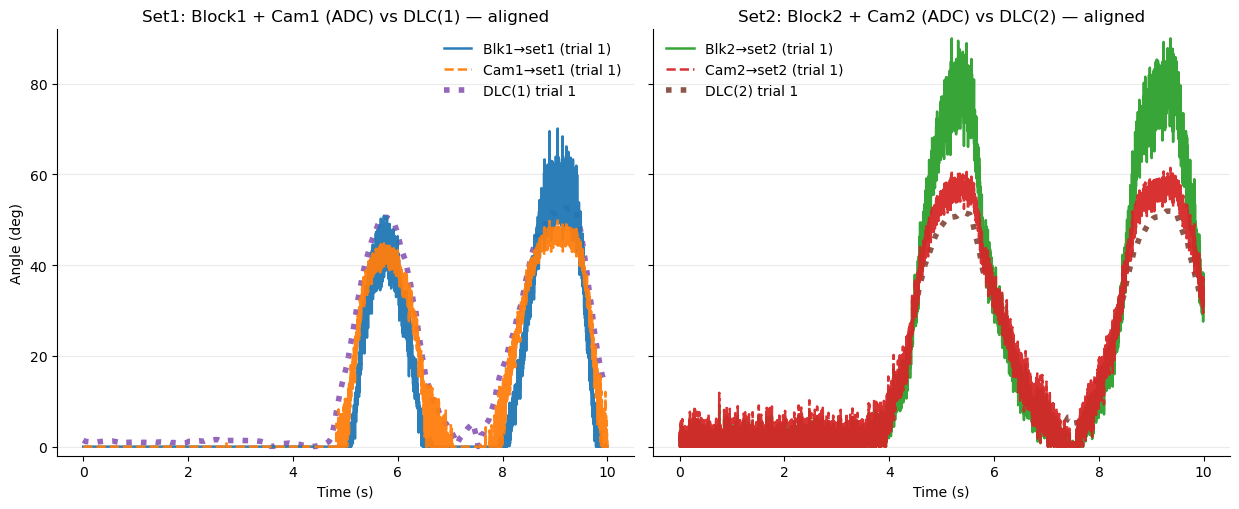

In [587]:

def cam_list_to_one_based_by_trial_id(cam_list):
    """
    Build a 1-based list where out[t] is the df whose 'trial'==t.
    Index 0 is left as None on purpose.
    If multiple dfs share the same stamped trial id, the last one wins.
    """
    # collect unique trial ids
    trial_ids = []
    for df in cam_list or []:
        if df is None or df.empty or "trial" not in df.columns:
            continue
        s = pd.to_numeric(df["trial"], errors="coerce").dropna().astype(int)
        if not s.empty:
            trial_ids.append(int(s.mode().iat[0]))
    if not trial_ids:
        return [None]  # only index 0

    max_id = max(trial_ids)
    out = [None] * (max_id + 1)   # index 0 unused

    for df in cam_list or []:
        if df is None or df.empty or "trial" not in df.columns:
            continue
        s = pd.to_numeric(df["trial"], errors="coerce").dropna().astype(int)
        if not s.empty:
            t = int(s.mode().iat[0])
            out[t] = df
    return out


# Convert camera+dlc lists to 1-based, so index == trial ID
cam_plus_dlc_first_1b  = cam_list_to_one_based_by_trial_id(cam_trials_first_cam)
cam_plus_dlc_second_1b = cam_list_to_one_based_by_trial_id(cam_trials_second_cam)

# Now you can pass trial_first=1 or 2 and both DLC & ADC will refer to the same trial ID.
bb.plot_adc_and_dlc_twopanel(
    out,
    cam_plus_dlc_first=cam_plus_dlc_first_1b,
    cam_plus_dlc_second=cam_plus_dlc_second_1b,
    aligned_first=aligned_first,     # these are already remapped so list index = trial ID - 1
    aligned_second=aligned_second,
    use_aligned=True,
    trial_first=1,    # first trial by ID
    trial_second=1,   # second trial by ID
    dlc_on_top=True, dlc_linewidth=4, dlc_alpha=1.0, dlc_zorder=1, adc_zorder=2,
)

print("DLC first 1-based slots present:", [i for i,df in enumerate(cam_plus_dlc_first_1b) if i>0 and df is not None])
print("Aligned first trial IDs present:",
      sorted(pd.to_numeric(pd.concat(aligned_first, ignore_index=True)["trial"], errors="coerce").dropna().astype(int).unique()))






[set1] trial idx 0: rows total=198, kept_by_dt=198, dt_ms 5/95% ~ -3.1 / 3.6
[set1] calib='blk1': kept 0 / rows 0
[set1] calib='cam1': kept 198 / rows 198
[set2] trial idx 0: rows total=197, kept_by_dt=197, dt_ms 5/95% ~ -3.2 / 3.4
[set2] calib='blk2': kept 0 / rows 0
[set2] calib='cam2': kept 197 / rows 197
[abs-err boxplots] done.


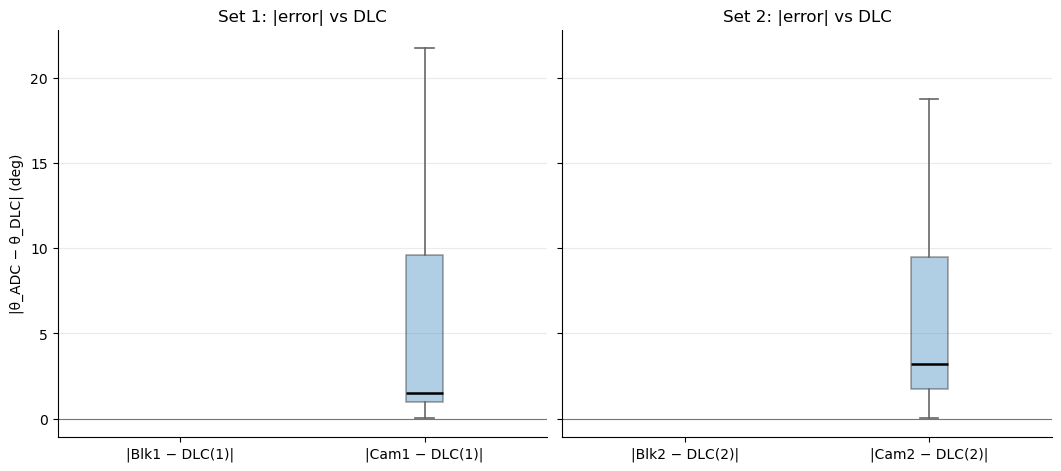

In [588]:
res_boxes = bb.plot_dlc_abs_error_boxplots_from_aligned(
    aligned_first=aligned_first,
    aligned_second=aligned_second,
    dlc_angle_col="metric_mcp_bend_deg_deg_dlc",  # change if your DLC col is different
    adc_theta_col="theta_pred_deg",
    calib_col="calib",           # must exist in aligned dfs (see note below)
    max_abs_dt_ms=10000.0,         # or None to keep all matches
    trial_first=None,            # None = all trials in set1
    trial_second=None,           # None = all trials in set2
    verbose=True
)


